<a href="https://colab.research.google.com/github/musicjae/Korean-NLP/blob/main/Keyword_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procedure

- [1] Execute sentiment analysis to use BERT  
- [2] Extract keywords to use KR-WordRank

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
!pip install transformers
!pip install krwordrank
!pip install soynlp
!pip install konlpy

     |████████████████████████████████| 19.4MB 319kB/s 
     |████████████████████████████████| 460kB 41.1MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## import

In [215]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import PreTrainedTokenizer
 
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import copy
import pandas as pd
import numpy as np
import random
import time

import pandas as pd
from krwordrank.word import KRWordRank
from krwordrank.hangle import normalize
from krwordrank.sentence import summarize_with_sentences
import re
import konlpy

import matplotlib.pyplot as plt

# 감성분석

#### 장치 설정

In [31]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### 토크나이저 로드

In [32]:
tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base", do_lower_case=False)

#### kcbert 모델 로드

In [33]:
model = BertForSequenceClassification.from_pretrained("beomi/kcbert-base", num_labels=2)
model.cuda()

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))

bert_path = '/content/drive/MyDrive/Colab_Notebooks/JJY/버트 감성 분석/bert_감성분석/bert.pth'
model.load_state_dict(torch.load(bert_path),strict=False)

<All keys matched successfully>

### 실제 예문 테스트

In [157]:

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks


def test_sentences(model,sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [206]:
def runrunrun(model,sen,scoreview=None):
    sen = [sen]
    score = test_sentences(model,sen)
    result = np.argmax(score)

    if result == 1:
        if abs(score[0][1]-score[0][0]) < 0.4:
            return 2
        else:
            return 1

    elif result == 0:
        if abs(score[0][1]-score[0][0]) < 1.5:
            return 2
        else:
            return 0

    if scoreview == True:
        print(scoreview)
    
num_neutral=0
num_positive = 0
num_negative = 0
pos_texts = []
neg_texts=[]
neu_texts = []

news = '/content/drive/MyDrive/Colab_Notebooks/JJY/notes/한국어 nlp/dataset/news.txt'
news = pd.read_csv(news,delimiter='\t')
#print(news.head(2))
#print(news.columns)
news = news[['title','header','contents']]

for sen in news.title:
    sen = sen.replace('[노트펫]','')
    sen = sen.replace('[에세이]','')
    sen = sen.replace(r'[^ ㄱ-ㅣ가-힣]+',' ') # 한글을 제외한 나머지 제거
    sen = re.sub('[-=.#/?:$\\}]', '', sen)
    sen = sen.replace('\'','')
    if runrunrun(model,sen) == 1:
        num_positive += 1
        pos_texts.append(sen)
    elif runrunrun(model,sen) == 0:
        num_negative += 1
        neg_texts.append(sen)
    elif runrunrun(model,sen) == 2:
        num_neutral += 1
        neu_texts.append(sen)

총 자료 개수:45



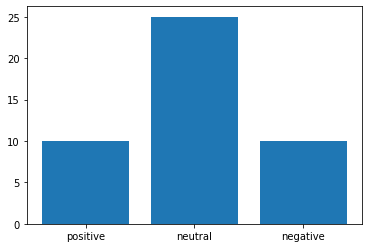

In [207]:
print(f'총 자료 개수:{len(news.title)}\n')
x = np.arange(3)

pos_neg = ['positive','neutral','negative']
values = [num_positive, num_neutral, num_negative]

plt.bar(x, values)
plt.xticks(x, pos_neg)
plt.show()

In [208]:
pos_texts

[' 냥이에게 하이파이브 요청했다 심쿵한 집사"머리꿍은 덤이다옹!"',
 '혜리, 블랙핑크 로제 반려견 행크와 애틋한 시간"나 집에 가지마',
 ' 냥이에게 하이파이브 요청했다 심쿵한 집사"머리꿍은 덤이다옹!"',
 '혜리, 블랙핑크 로제 반려견 행크와 애틋한 시간"나 집에 가지마',
 ' 냥이에게 하이파이브 요청했다 심쿵한 집사"머리꿍은 덤이다옹!"',
 '혜리, 블랙핑크 로제 반려견 행크와 애틋한 시간"나 집에 가지마',
 ' 냥이에게 하이파이브 요청했다 심쿵한 집사"머리꿍은 덤이다옹!"',
 '혜리, 블랙핑크 로제 반려견 행크와 애틋한 시간"나 집에 가지마',
 ' 냥이에게 하이파이브 요청했다 심쿵한 집사"머리꿍은 덤이다옹!"',
 '혜리, 블랙핑크 로제 반려견 행크와 애틋한 시간"나 집에 가지마']

In [209]:
neu_texts

['축구 골대 그물에 감겨 의식 잃은 고양이, 심폐소생술로 살려준 소방관들',
 '쉼터 대신 쓰레기 봉지 집 선택한 노숙인"강아지들 두고 갈 수 없',
 '되감기 아님눈 밟기 싫어 자기 발자국 그대로 되짚어 간 똑냥이',
 '절친 강아지가 무지개다리 건넌 줄 모르고 매일 이웃집 들르는 시바견',
 '서현, 반려견 뽀뽀 품에 안고 폭풍 애정 표현뽀뽀 쪽"',
 '축구 골대 그물에 감겨 의식 잃은 고양이, 심폐소생술로 살려준 소방관들',
 '쉼터 대신 쓰레기 봉지 집 선택한 노숙인"강아지들 두고 갈 수 없',
 '되감기 아님눈 밟기 싫어 자기 발자국 그대로 되짚어 간 똑냥이',
 '절친 강아지가 무지개다리 건넌 줄 모르고 매일 이웃집 들르는 시바견',
 '서현, 반려견 뽀뽀 품에 안고 폭풍 애정 표현뽀뽀 쪽"',
 '축구 골대 그물에 감겨 의식 잃은 고양이, 심폐소생술로 살려준 소방관들',
 '쉼터 대신 쓰레기 봉지 집 선택한 노숙인"강아지들 두고 갈 수 없',
 '되감기 아님눈 밟기 싫어 자기 발자국 그대로 되짚어 간 똑냥이',
 '절친 강아지가 무지개다리 건넌 줄 모르고 매일 이웃집 들르는 시바견',
 '서현, 반려견 뽀뽀 품에 안고 폭풍 애정 표현뽀뽀 쪽"',
 '축구 골대 그물에 감겨 의식 잃은 고양이, 심폐소생술로 살려준 소방관들',
 '쉼터 대신 쓰레기 봉지 집 선택한 노숙인"강아지들 두고 갈 수 없',
 '되감기 아님눈 밟기 싫어 자기 발자국 그대로 되짚어 간 똑냥이',
 '절친 강아지가 무지개다리 건넌 줄 모르고 매일 이웃집 들르는 시바견',
 '서현, 반려견 뽀뽀 품에 안고 폭풍 애정 표현뽀뽀 쪽"',
 '축구 골대 그물에 감겨 의식 잃은 고양이, 심폐소생술로 살려준 소방관들',
 '쉼터 대신 쓰레기 봉지 집 선택한 노숙인"강아지들 두고 갈 수 없',
 '되감기 아님눈 밟기 싫어 자기 발자국 그대로 되짚어 간 똑냥이',
 '절친 강아지가 무지개다리 건넌 줄 모르고 매일 이웃집 들르는 시바견',
 '서현, 반려견 뽀뽀 품에 안고 폭풍 애정 표현뽀뽀 

In [210]:
neg_texts

[' 장난감 사냥하다 당황한 맹수 꿈나무 고양이 "오디 갔지"',
 ' 아빠 학원 따라갔다 사고 친 강아지강제 공부에 댕무룩',
 ' 장난감 사냥하다 당황한 맹수 꿈나무 고양이 "오디 갔지"',
 ' 아빠 학원 따라갔다 사고 친 강아지강제 공부에 댕무룩',
 ' 장난감 사냥하다 당황한 맹수 꿈나무 고양이 "오디 갔지"',
 ' 아빠 학원 따라갔다 사고 친 강아지강제 공부에 댕무룩',
 ' 장난감 사냥하다 당황한 맹수 꿈나무 고양이 "오디 갔지"',
 ' 아빠 학원 따라갔다 사고 친 강아지강제 공부에 댕무룩',
 ' 장난감 사냥하다 당황한 맹수 꿈나무 고양이 "오디 갔지"',
 ' 아빠 학원 따라갔다 사고 친 강아지강제 공부에 댕무룩']

# 키워드 추출

In [263]:
tok = konlpy.tag.Okt()

sen = """
대검찰청 과거사 진상조사단에 소속돼 ‘김학의 사건’을 조사했던 박준영 변호사가 “김학의 전 법무부 차관 사건으로 현실을 무시하며, 졸속으로 진행되는 이 개혁 아닌 (검찰)개혁에 대해 하나하나 설명하며 문제를 제기하겠다”고 밝혔다.

박 변호사는 2일 자신의 페이스북에 올린 ‘난전(難戰) 준비’란 제목의 글에서 ‘김학의 사건’을 공론화할 예정이라고 적었다. 그는 “김 전 차관 사건을 가지고 개혁을 이야기하는 그들을 상대로 김 전 차관 사건으로 반박을 해보겠다”고 말했다. 박 변호사는 2018년 2월부터 이듬해 3월까지 대검 진상조사단에서 ‘김 전 차관 별장 성접대 의혹 사건’을 조사했다.

박 변호사는 ‘김학의 사건’의 공론화 원칙과 방식에 대해 “총장을 죽이려고, 불리한 수사를 그만 두게끔 하려고 1000페이지가 넘는 김 전 차관 보고서를 언론에 흘린 그들과 (내가) 똑같을 순 없다”며 “정치적이라는 오해를 받지 않도록 공익적 목적을 점검하고 또 점검하겠다”고 말했다.

그는 “별장 동영상이 어떻게 세상 밖에 나오게 됐는지 그리고 이를 이용해 돈을 뜯어내려는 과정에서 벌어진 추악한 일들은 드러내지 않고, 동영상 속 남성을 김 전 차관으로 추정했음에도 이를 불기소 이유에 담지 않은 이유에 대한 검사들 의견도 외면하며 사건을 이야기할 수 없다"고도 주장했다.

박 변호사는 윤석열 검찰총장도 건설업자 윤중천씨 접대 리스트에 있었다는 의혹을 제기한 한 언론 보도를 언급하며 “보고서를 근거로 단독 보도가 정당하다는 주장을 이어갔으면서 정작 보고서에 담긴 다른 문제점과 모순에는 침묵했던 언론에 대해서도 비판해야 한다"고 지적하기도 했다.
"""
word_list = []

for word in sen.split(sep='\n'):
    word = tok.pos(word)
    if len(word) != 0:
        for i in range(len(word)):

            if word[i][1] == 'Noun':
                word_list.append(word[i][0])
print(word_list)


['대검찰청', '과거', '사', '진상', '사단', '소속', '김학의', '사건', '조사', '박준영', '변호사', '김학의', '전', '법무부', '차관', '사건', '현실', '무시', '졸속', '진행', '이', '개혁', '검찰', '개혁', '대해', '하나', '하나', '설명', '문제', '제기', '고', '박', '변호사', '자신', '페이스북', '난전', '준비', '란', '제목', '글', '김학의', '사건', '공론', '예정', '그', '김', '전', '차관', '사건', '가지', '개혁', '이야기', '그', '상대로', '김', '전', '차관', '사건', '반박', '고', '말', '박', '변호사', '이듬해', '대검', '진상', '사단', '김', '전', '차관', '별장', '접대', '의혹', '사건', '조사', '박', '변호사', '김학의', '사건', '의', '공론', '원칙', '방식', '대해', '총장', '수사', '페이지', '김', '전', '차관', '보고서', '언론', '그', '내', '순', '며', '정치', '오해', '공익', '목적', '점검', '또', '점검', '고', '말', '그', '별장', '동영상', '세상', '이용', '돈', '과정', '일', '동영상', '속', '남성', '김', '전', '차관', '추정', '불기소', '이유', '이유', '대한', '검사', '의견', '외면', '사건', '이야기', '수', '고도', '주장', '박', '변호사', '윤석열', '검찰총장', '건설업', '윤중천', '접대', '리스트', '의혹', '제기', '언론', '보도', '언급', '보고서', '근거', '단독', '보도', '주장', '정작', '보고서', '다른', '문제점', '모순', '침묵', '언론', '대해', '서도', '비판', '고', '지적']


In [266]:
texts = news.contents
texts = [normalize(text,english=False,number=True) for text in texts]

stopword= {'지영','있는','있다','지난','모습이','피망이','씨는','라고','비루는'}

keywords,sents = summarize_with_sentences(
    pos_texts,
    stopwords = stopword,
    diversity=0.5,
    num_keywords=10,
    num_keysents=10,
    verbose=True
)

word_list = []

for word,r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    word = tok.pos(word)
    if len(word) != 0:
        for i in range(len(word)):

            if word[i][1] == 'Noun':
                word_list.append('#'+word[i][0])
print(word_list)

scan vocabs ... 
num vocabs = 95
done
['#냥', '#덤', '#옹', '#집사', '#머리', '#꿍', '#하이파이브', '#요청', '#집', '#로제', '#혜리']


In [267]:
wordrank_extractor = KRWordRank(
    min_count=2,
    max_length=10,
    verbose=True
)

beta = 0.85
max_iter=10

keywords,rank,graph = wordrank_extractor.extract(texts,beta,max_iter)


word_list = []

for word,r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    word = tok.pos(word)
    if len(word) != 0:
        for i in range(len(word)):

            if word[i][1] == 'Noun':
                word_list.append('#'+word[i][0])
print(word_list)


scan vocabs ... 
num vocabs = 3374
done
['#고양이', '#사진', '#지영', '#피망', '#노트', '#펫', '#지난', '#모습', '#구름', '#씨', '#비루', '#하이파이브', '#보호', '#반려견', '#멤버', '#그녀', '#집사', '#녀석', '#엄마', '#출동', '#뽀뽀', '#콜레']
